# Prediciting Evolutionary Dynamics of Microbial Systems with  Reinforcement Learning and Dynamic Flux Balance Analysis



## Overal View of the Algorithm

![img](Process.svg)

### Step 1: Define the Constants and Load The Toy Networks

In [ ]:
from cobra import Model, Reaction, Metabolite

"""
A Toy Model is a Cobra Model with the following:

Toy_Model_SA

Reactions(NOT BALANCED):

-> S  Substrate uptake
S + ADP -> S_x + ATP  ATP production from catabolism
ATP -> ADP ATP maintenance
S_x + ATP -> X + ADP  Biomass production
S_x + ATP -> Amylase + ADP  Amylase production
Amylase -> Amylase Exchange
X -> Biomass Out
S_x + ADP -> P + ATP Metabolism stuff!
P ->  Product release

Metabolites:

P  Product
S  Substrate
S_x  Internal metabolite
X  Biomass
ADP  
ATP
Amylase

-----------------------------------------------------------------------


Toy_Model_NE_1:


EX_S_sp1: S -> lowerBound',-10,'upperBound',0
EX_A_sp1: A -> lowerBound',-100,'upperBound',100
EX_B_sp1: B -> lowerBound',-100,'upperBound',100
EX_P_sp1: P->  lowerBound',0,'upperBound',100
R_1_sp1: S  + 2 adp  -> P + 2 atp ,'lowerBound',0,'upperBound',Inf
R_2_sp1: P + atp  -> B  + adp 'lowerBound',0,'upperBound',Inf
R_3_sp1: P + 3 atp  -> A + 3 adp ,'lowerBound',0,'upperBound',Inf
R_4_sp1: 'atp -> adp  lowerBound',0,'upperBound',Inf
OBJ_sp1: 3 A + 3 B + 5 atp  -> 5 adp + biomass_sp1 lowerBound',0,'upperBound',Inf
Biomass_1 biomass_sp1  -> ','lowerBound',0,'upperBound',Inf,'objectiveCoef', 1);





Toy_Model_NE_2:


EX_S_sp1: S -> lowerBound',-10,'upperBound',0
EX_A_sp1: A -> lowerBound',-100,'upperBound',100
EX_B_sp1: B -> lowerBound',-100,'upperBound',100
EX_P_sp1: P->  lowerBound',0,'upperBound',100
R_1_sp1: S  + 2 adp  -> P + 2 atp ,'lowerBound',0,'upperBound',Inf
R_2_sp1: P + atp  -> B  + adp 'lowerBound',0,'upperBound',Inf
R_3_sp1: P + 3 atp  -> A + 3 adp ,'lowerBound',0,'upperBound',Inf
R_4_sp1: 'atp -> adp  lowerBound',0,'upperBound',Inf
OBJ_sp1: 3 A + 3 B + 5 atp  -> 5 adp + biomass_sp1 lowerBound',0,'upperBound',Inf
Biomass_1 biomass_sp1  -> ','lowerBound',0,'upperBound',Inf,'objectiveCoef', 1);

"""


Toy_Model_NE_1 = Model('Toy_1')

### S_Uptake ###

EX_S_sp1 = Reaction('EX_S_sp1')
S = Metabolite('S', compartment='c')
EX_S_sp1.add_metabolites({S: -1})
EX_S_sp1.lower_bound = -10
EX_S_sp1.upper_bound = 0
Toy_Model_NE_1.add_reaction(EX_S_sp1)


EX_A_sp1 = Reaction('EX_A_sp1')
A = Metabolite('A', compartment='c')
EX_A_sp1.add_metabolites({A: -1})
EX_A_sp1.lower_bound = -100
EX_A_sp1.upper_bound = 100
Toy_Model_NE_1.add_reaction(EX_A_sp1)


EX_B_sp1 = Reaction('EX_B_sp1')
B = Metabolite('B', compartment='c')
EX_B_sp1.add_metabolites({B: -1})
EX_B_sp1.lower_bound = -100
EX_B_sp1.upper_bound = 100
Toy_Model_NE_1.add_reaction(EX_B_sp1)



EX_P_sp1 = Reaction('EX_P_sp1')
P = Metabolite('P', compartment='c')
EX_P_sp1.add_metabolites({P:-1})
EX_P_sp1.lower_bound = 0
EX_P_sp1.upper_bound = 100
Toy_Model_NE_1.add_reaction(EX_P_sp1)


R_1_sp1 = Reaction('R_1_sp1')
ADP = Metabolite('ADP', compartment='c')
ATP = Metabolite('ATP', compartment='c')
R_1_sp1.add_metabolites({ADP: -2, S: -1, P: 1, ATP: 2})
R_1_sp1.lower_bound = 0
R_1_sp1.upper_bound = 1000
Toy_Model_NE_1.add_reaction(R_1_sp1)


R_2_sp1 = Reaction('R_2_sp1')
R_2_sp1.add_metabolites({ADP: 1, P: -1, B: 1, ATP: -1})
R_2_sp1.lower_bound = 0
R_2_sp1.upper_bound = 1000
Toy_Model_NE_1.add_reaction(R_2_sp1)


# R_3_sp1 = Reaction('R_3_sp1')
# R_3_sp1.add_metabolites({ADP: 3, P: -1, A: 1, ATP: -3})
# R_3_sp1.lower_bound = 0
# R_3_sp1.upper_bound = 1000
# Toy_Model_NE_1.add_reaction(R_3_sp1)



R_4_sp1 = Reaction('R_4_sp1')
R_4_sp1.add_metabolites({ADP:1 ,ATP: -1})
R_4_sp1.lower_bound = 0
R_4_sp1.upper_bound = 1000
Toy_Model_NE_1.add_reaction(R_4_sp1)




OBJ_sp1 = Reaction("OBJ_sp1")
biomass_sp1 = Metabolite('biomass_sp1', compartment='c')
OBJ_sp1.add_metabolites({ADP:5 ,ATP: -5,biomass_sp1:0.01,A:-3,B:-3})
OBJ_sp1.lower_bound = 0
OBJ_sp1.upper_bound = 1000
Toy_Model_NE_1.add_reaction(OBJ_sp1)

Biomass_1 = Reaction("Biomass_1")
Biomass_1.add_metabolites({biomass_sp1:-1})
Biomass_1.lower_bound = 0
Biomass_1.upper_bound = 1000
Toy_Model_NE_1.add_reaction(Biomass_1)

Toy_Model_NE_1.objective='Biomass_1'
Toy_Model_NE_1.Biomass_Ind=8


### ADP Production From Catabolism ###

Toy_Model_NE_2 = Model('Toy_2')

### S_Uptake ###

EX_S_sp2 = Reaction('EX_S_sp2')
S = Metabolite('S', compartment='c')
EX_S_sp2.add_metabolites({S: -1})
EX_S_sp2.lower_bound = -10
EX_S_sp2.upper_bound = 0
Toy_Model_NE_2.add_reaction(EX_S_sp2)


EX_A_sp2 = Reaction('EX_A_sp2')
A = Metabolite('A', compartment='c')
EX_A_sp2.add_metabolites({A: -1})
EX_A_sp2.lower_bound = -100
EX_A_sp2.upper_bound = 100
Toy_Model_NE_2.add_reaction(EX_A_sp2)


EX_B_sp2 = Reaction('EX_B_sp2')
B = Metabolite('B', compartment='c')
EX_B_sp2.add_metabolites({B: -1})
EX_B_sp2.lower_bound = -100
EX_B_sp2.upper_bound = 100
Toy_Model_NE_2.add_reaction(EX_B_sp2)



EX_P_sp2 = Reaction('EX_P_sp2')
P = Metabolite('P', compartment='c')
EX_P_sp2.add_metabolites({P:-1})
EX_P_sp2.lower_bound = 0
EX_P_sp2.upper_bound = 100
Toy_Model_NE_2.add_reaction(EX_P_sp2)


R_1_sp2 = Reaction('R_1_sp2')
ADP = Metabolite('ADP', compartment='c')
ATP = Metabolite('ATP', compartment='c')
R_1_sp2.add_metabolites({ADP: -2, S: -1, P: 1, ATP: 2})
R_1_sp2.lower_bound = 0
R_1_sp2.upper_bound = 1000
Toy_Model_NE_2.add_reaction(R_1_sp2)


# R_2_sp2 = Reaction('R_2_sp2')
# R_2_sp2.add_metabolites({ADP: 3, P: -1, B: 1, ATP: -3})
# R_2_sp2.lower_bound = 0
# R_2_sp2.upper_bound = 1000
# Toy_Model_NE_2.add_reaction(R_2_sp2)


R_3_sp2 = Reaction('R_3_sp2')
R_3_sp2.add_metabolites({ADP: 1, P: -1, A: 1, ATP: -1})
R_3_sp2.lower_bound = 0
R_3_sp2.upper_bound = 1000
Toy_Model_NE_2.add_reaction(R_3_sp2)



R_4_sp2 = Reaction('R_4_sp2')
R_4_sp2.add_metabolites({ADP:1 ,ATP: -1})
R_4_sp2.lower_bound = 0
R_4_sp2.upper_bound = 1000
Toy_Model_NE_2.add_reaction(R_4_sp2)




OBJ_sp2 = Reaction("OBJ_sp2")
biomass_sp2 = Metabolite('biomass_sp2', compartment='c')
OBJ_sp2.add_metabolites({ADP:5 ,ATP: -5,biomass_sp2:0.01,A:-3,B:-3})
OBJ_sp2.lower_bound = 0
OBJ_sp2.upper_bound = 1000
Toy_Model_NE_2.add_reaction(OBJ_sp2)

Biomass_2 = Reaction("Biomass_2")
Biomass_2.add_metabolites({biomass_sp2:-1})
Biomass_2.lower_bound = 0
Biomass_2.upper_bound = 1000
Toy_Model_NE_2.add_reaction(Biomass_2)
Toy_Model_NE_2.objective="Biomass_2"
Toy_Model_NE_2.Biomass_Ind=8




if __name__ == '__main__':
    print(ToyModel_SA.optimize().fluxes)
    print(ToyModel_SA.exchanges)
    print(Toy_Model_NE_1.optimize().fluxes)
    print(Toy_Model_NE_1.exchanges)
    print(Toy_Model_NE_2.optimize().fluxes)
    print(Toy_Model_NE_2.exchanges)

In [139]:
NUMBER_OF_BATCHES=1000
BATCH_SIZE=8
HIDDEN_SIZE=30
PERCENTILE=70

import os 
import datetime
import numpy as np
import cobra
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import pickle
import pandas
#import cplex
from ToyModel import  Toy_Model_NE_1,Toy_Model_NE_2
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
import ray
from sklearn.preprocessing import StandardScaler
from tensorboardX import SummaryWriter
from heapq import heappop, heappush

### Then we have to define a number of classes, objects, and functions that will be used during the simulations!

In [161]:
Scaler=StandardScaler()
CORES = multiprocessing.cpu_count()
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])
Main_dir = os.path.dirname(".")
torch.manual_seed(0)

class ProrityQueue:
    
    def __init__(self,N):
        self.N=N
        self.Elements=[]
    
    def enqueue_with_priority(self,Step):
        Element = (-Step[0], random.random(),Step[1],Step[2])
        heappush(self.Elements, Element)

    def dequeue(self):
        heappop(self.Elements)
    
    def balance(self):
        while len(self.Elements)>=self.N:
            self.dequeue()
    
    
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions),
            
        )

    def forward(self, x):
        return self.net(x)



### Definition of DFBA function

In [166]:
@ray.remote
def dFBA(Models, Mapping_Dict: dict, Init_C:np.ndarray, Params:dict, t_span:list, dt=1)->list:
    """
    This function calculates the concentration of each species
    Models is a list of COBRA Model objects
    Mapping_Dict is a dictionary of dictionaries
    """
    ##############################################################
    # Initializing the ODE Solver
    ##############################################################
    t = np.arange(t_span[0], t_span[1], dt)
    ##############################################################
    # Solving the ODE
    ##############################################################
    for m in Models:
        m.episode_reward=0
        m.episode_steps=[]
    
    sol, t = odeFwdEuler(ODE_System, Init_C, dt,  Params,
                         t_span, Models, Mapping_Dict)
    
    for i,m in enumerate(Models):
        m.Episode=Episode(reward=m.episode_reward, steps=m.episode_steps)




    return [m.Episode for m in Models]


def ODE_System(C, t, Models, Mapping_Dict, Params, dt):
    """
    This function calculates the differential equations for the system
    Models is a list of COBRA Model objects
    NOTE: this implementation of DFBA is compatible with RL framework
    Given a policy it will genrate episodes. Policies can be either deterministic or stochastic
    Differential Equations Are Formatted as follows:
    [0]-Models[1]
    [1]-Models[2]
    []-...
    [n-1]-Models[n]
    [n]-Exc[1]
    [n+1]-Exc[2]
    []-...
    [n+m-1]-Exc[m]
    [n+m]-Starch
    """
    C[C < 0] = 0
    dCdt = np.zeros(C.shape)
    Sols = list([0 for i in range(Models.__len__())])
    for i,M in enumerate(Models):
        
        if random.random()<M.epsilon:

            M.a=M.Policy(torch.FloatTensor([C[M.observables]])).detach().numpy()[0]*(1-M.epsilon)+np.random.uniform(low=-5, high=5,size=len(M.actions))*M.epsilon
        
        else:

            M.a=M.Policy(torch.FloatTensor([C[M.observables]])).detach().numpy()[0]
        
        for index,item in enumerate(Mapping_Dict["Ex_sp"]):
            if Mapping_Dict['Mapping_Matrix'][index,i]!=-1:
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].upper_bound=20
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].lower_bound=-General_Uptake_Kinetics(C[index+len(Models)])
                
            
        for index,flux in enumerate(M.actions):
            M.a[index]=Flux_Clipper(M.reactions[M.actions[index]].lower_bound,M.a[index],M.reactions[M.actions[index]].upper_bound)
            M.reactions[M.actions[index]].lower_bound=M.a[index]
            # M.reactions[M.actions[index]].upper_bound=M.a[index]

        Sols[i] = Models[i].optimize()

        if Sols[i].status == 'infeasible':
            Models[i].reward= 0
            dCdt[i] = 0

        else:
            dCdt[i] += Sols[i].objective_value*C[i]
            Models[i].reward =Sols[i].objective_value



    ### Writing the balance equations

    for i in range(Mapping_Dict["Mapping_Matrix"].shape[0]):
        for j in range(len(Models)):
            if Mapping_Dict["Mapping_Matrix"][i, j] != -1:
                if Sols[j].status == 'infeasible':
                    dCdt[i] = 0
                else:
                    dCdt[i+len(Models)] += Sols[j].fluxes.iloc[Mapping_Dict["Mapping_Matrix"]
                                                                    [i, j]]*C[j]


    for m in Models:
        m.episode_reward += m.reward
        m.episode_steps.append(EpisodeStep(observation=C[m.observables], action=m.a))
    
    dCdt += np.array(Params["Dilution_Rate"])*(Params["Inlet_C"]-C)
    
    return dCdt

### Now we need some utility functions!

In [167]:
def Build_Mapping_Matrix(Models):
    """
    Given a list of COBRA model objects, this function will build a mapping matrix

    """

    Ex_sp = []
    Temp_Map={}
    for model in Models:
        
        
        if not hasattr(model,"Biomass_Ind"):
            raise Exception("Models must have 'Biomass_Ind' attribute in order for the DFBA to work properly!")
        
        
        for Ex_rxn in model.exchanges :
            if Ex_rxn!=model.reactions[model.Biomass_Ind]:
                if list(Ex_rxn.metabolites.keys())[0].id not in Ex_sp:
                    Ex_sp.append(list(Ex_rxn.metabolites.keys())[0].id)
                if list(Ex_rxn.metabolites.keys())[0].id in Temp_Map.keys():
                   Temp_Map[list(Ex_rxn.metabolites.keys())[0].id][model]=Ex_rxn
                else:
                     Temp_Map[list(Ex_rxn.metabolites.keys())[0].id]={model:Ex_rxn}

    Mapping_Matrix = np.zeros((len(Ex_sp), len(Models)), dtype=int)
    for i, id in enumerate(Ex_sp):
        for j, model in enumerate(Models):
            if model in Temp_Map[id].keys():
                Mapping_Matrix[i, j] = model.reactions.index(Temp_Map[id][model].id)
            else:
                Mapping_Matrix[i, j] = -1
    return {"Ex_sp": Ex_sp, "Mapping_Matrix": Mapping_Matrix}




def General_Uptake_Kinetics(Compound: float, Model=""):
    """
    This function calculates the rate of uptake of a compound in the reactor
    ###It is just a simple imaginary model: Replace it with better model if necessary###
    Compound Unit: mmol

    """
    return 30*(Compound/(Compound+20))





def odeFwdEuler(ODE_Function, ICs, dt, Params, t_span, Models, Mapping_Dict):
    Integrator_Counter = 0
    t = np.arange(t_span[0], t_span[1], dt)
    sol = np.zeros((len(t), len(ICs)))
    sol[0] = ICs
    for i in range(1, len(t)):
        sol[i] = sol[i-1] + \
            ODE_Function(sol[i-1], t[i-1], Models, Mapping_Dict,
                         Params, dt)*dt
        Integrator_Counter += 1
    return sol, t


def Generate_Batch(dFBA, Params, Init_C, Models, Mapping_Dict, Batch_Size=10,t_span=[0, 100], dt=0.1):


    Init_C[list(Params["Env_States"])] = [random.uniform(Range[0], Range[1]) for Range in Params["Env_States_Initial_Ranges"]]
    

    
    Batch_Episodes=[]
    for BATCH in range(Batch_Size):
        Batch_Episodes.append(dFBA.remote(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt))
        # Batch_Episodes.append(dFBA(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt))

    return(ray.get(Batch_Episodes))    

    # return(Batch_Episodes)    


def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for example in batch:
        if example.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, example.steps))
        train_act.extend(map(lambda step: step.action, example.steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.FloatTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


def Flux_Clipper(Min,Number,Max):
    return(min(max(Min,Number),Max))

### We now define the high level main function that controls every part of the code

In [168]:
def main(Models: list = [Toy_Model_NE_1.copy(), Toy_Model_NE_2.copy()], max_time: int = 100, Dil_Rate: float = 0.000000001, alpha: float = 0.01, Starting_Q: str = "FBA")->None:
    """
    This is the main function for running dFBA.
    The main requrement for working properly is
    that the models use the same notation for the
    same reactions.

    Starting_Policy:

    Defult --> Random: Initial Policy will be a random policy for all agents.
    Otherwise --> a list of policies, pickle file addresses, for each agent.


    """
    # Adding Agents info ###-----------------------------------------------------

    # State dimensions in this RLDFBA variant include: [Agent1,...,Agentn, glucose,starch]
    for i in range(len(Models)):
        if not hasattr(Models[i], "_name"):
            Models[i].NAME = "Agent_" + str(i)
            print(f"Agent {i} has been given a defult name")
        Models[i].solver.objective.name = "_pfba_objective"
    # -------------------------------------------------------------------------------

    # Mapping internal reactions to external reactions, and operational parameter
    # setup ###-------------------------------------------------------------------

    # For more information about the structure of the ODEs,see ODE_System function
    # or the documentation.

    Mapping_Dict = Build_Mapping_Matrix(Models)
    Init_C = np.ones((len(Models)+len(Mapping_Dict["Ex_sp"]),))
    Inlet_C = np.zeros((len(Models)+len(Mapping_Dict["Ex_sp"]),))

    #Parameters that are use inside DFBA

    Params = {
        "Dilution_Rate": Dil_Rate,
        "Inlet_C": Inlet_C,
        "Agents_Index": [i for i in range(len(Models))],
    }

    #Define Agent attributes
    Obs=[i for i in range(len(Models))]
    Obs.extend([Mapping_Dict["Ex_sp"].index(sp)+len(Models) for sp in Mapping_Dict["Ex_sp"] if sp!='P' ])
    for ind,m in enumerate(Models):
        m.observables=Obs
        m.actions=(Mapping_Dict["Mapping_Matrix"][Mapping_Dict["Ex_sp"].index("A"),ind],Mapping_Dict["Mapping_Matrix"][Mapping_Dict["Ex_sp"].index("B"),ind])
        m.Policy=Net(len(m.observables), HIDDEN_SIZE, len(m.actions))
        m.optimizer=optim.SGD(params=m.Policy.parameters(), lr=0.01)
        m.Net_Obj=nn.MSELoss()
        m.epsilon=0.05
        
    ### I Assume that the environment states are all observable. Env states will be stochastic
    Params["Env_States"]=Models[0].observables
    Params["Env_States_Initial_Ranges"]=[[0.1,0.1+0.00000001],[0.1,0.1+0.00000001],[100,100+0.00001],[0.001,0.001+0.00000000001],[0.001,0.001+0.00000000001]]
    for i in range(len(Models)):
        Init_C[i] = 0.001
        #Models[i].solver = "cplex"
    writer = SummaryWriter(comment="-DeepRLDFBA_NECOM")
    Outer_Counter = 0


    for c in range(NUMBER_OF_BATCHES):
        for m in Models:
            m.epsilon=0.01+0.99/(np.exp(c/20))
        Batch_Out=Generate_Batch(dFBA, Params, Init_C, Models, Mapping_Dict,Batch_Size=BATCH_SIZE)
        Batch_Out=list(map(list, zip(*Batch_Out)))
        for index,Model in enumerate(Models):
            obs_v, acts_v, reward_b, reward_m=filter_batch(Batch_Out[index], PERCENTILE)
            Model.optimizer.zero_grad()
            action_scores_v = Model.Policy(obs_v)
            loss_v = Model.Net_Obj(action_scores_v, acts_v)
            loss_v.backward()
            Model.optimizer.step()
            print(f"{Model.NAME}")
            print("%d: loss=%.3f, reward_mean=%.4f, reward_bound=%.4f" % (c, loss_v.item(), reward_m, reward_b))

            writer.add_scalar(f"{Model.NAME} reward_mean", reward_m, c)
    
    Time=datetime.datetime.now().strftime("%d_%m_%Y.%H_%M_%S")
    Results_Dir=os.path.join(Main_dir,"Outputs",str(Time))
    os.mkdir(Results_Dir)
    with open(os.path.join(Results_Dir,"Models.pkl"),'wb') as f:
        pickle.dump(Models,f)
    return Models

### Finally it's time to run!!!

In [169]:
Models=main([Toy_Model_NE_1.copy(),Toy_Model_NE_2.copy()])

Agent 0 has been given a defult name
Agent 1 has been given a defult name
Agent_0
0: loss=4.624, reward_mean=1.3279, reward_bound=1.3753
Agent_1
0: loss=5.169, reward_mean=1.5077, reward_bound=1.5842


KeyboardInterrupt: 

## Step n: Plotting the policy

Observation space of each agent **in this particular example** is similar and contains 5 different states. Our goal is to create a meshgrid dataframe that includes these states and the actions taken as columns 

In [71]:
import plotly.graph_objects as go
import pandas as pd

One way is to make a mesh grid which might be inefficient, probably is! So I won't complete it for now.

In [72]:
Ag1=np.linspace(0,10,10)
Ag2=np.linspace(0,10,10)
S=np.linspace(0,100,10)
A=np.linspace(0,10,10)
B=np.linspace(0,10,10)
Meshgrid=np.meshgrid(Ag1,Ag2,S,A,B)

A much faster way is to generate a bunch of random points in the desired mesh and input them to the policy network

In [73]:
Space_Size=10000
Space=np.random.uniform(low=[0,0,0,0,0],high=[10,10,100,10,10],size=(Space_Size,5))
Actions_1=Models[0].Policy(torch.FloatTensor(Space))
Actions_2=Models[1].Policy(torch.FloatTensor(Space))



In [74]:

DF_1=pd.DataFrame(np.hstack((Space,Actions_1.detach().numpy())),columns=["Agent1","Agent2","S","A","B","A_Export","B_Export"])

DF_2=pd.DataFrame(np.hstack((Space,Actions_2.detach().numpy())),columns=["Agent1","Agent2","S","A","B","A_Export","B_Export"])

In [80]:
(DF_2["A_Export"]<0).sum()

7139

## Run a simulation with the trained models

In [112]:
def main_t(Models: list = [Toy_Model_NE_1.copy(), Toy_Model_NE_2.copy()], max_time: int = 100, Dil_Rate: float = 0.000000001, alpha: float = 0.01, Starting_Q: str = "FBA"):
    """
    This is the main function for running dFBA.
    The main requrement for working properly is
    that the models use the same notation for the
    same reactions.

    Starting_Policy:

    Defult --> Random: Initial Policy will be a random policy for all agents.
    Otherwise --> a list of policies, pickle file addresses, for each agent.


    """


    Mapping_Dict = Build_Mapping_Matrix(Models)
    Init_C = np.ones((len(Models)+len(Mapping_Dict["Ex_sp"]),))
    Inlet_C = np.zeros((len(Models)+len(Mapping_Dict["Ex_sp"]),))

    #Parameters that are use inside DFBA

    Params = {
        "Dilution_Rate": Dil_Rate,
        "Inlet_C": Inlet_C,
        "Agents_Index": [i for i in range(len(Models))],
    }

    #Define Agent attributes

    ### I Assume that the environment states are all observable. Env states will be stochastic
    Params["Env_States"]=Models[0].observables
    Params["Env_States_Initial_Ranges"]=[[0.1,0.100001],[0.1,0.100001],[50,50.001],[0.01,0.01+0.000001],[0.01,0.01+0.00001]]

    Sol,t=Generate_Batch_t(dFBA, Params, Init_C, Models, Mapping_Dict)
    return Sol,t
    


def dFBA_t(Models, Mapping_Dict, Init_C, Params, t_span, dt=0.1):
    """
    This function calculates the concentration of each species
    Models is a list of COBRA Model objects
    Mapping_Dict is a dictionary of dictionaries
    """
    ##############################################################
    # Initializing the ODE Solver
    ##############################################################
    t = np.arange(t_span[0], t_span[1], dt)
    ##############################################################
    # Solving the ODE
    ##############################################################

    
    sol, t = odeFwdEuler(ODE_System_t, Init_C, dt,  Params,
                         t_span, Models, Mapping_Dict)
    
    return sol,t





def ODE_System_t(C, t, Models, Mapping_Dict, Params, dt):
    """
    This function calculates the differential equations for the system
    Models is a list of COBRA Model objects
    NOTE: this implementation of DFBA is compatible with RL framework
    Given a policy it will genrate episodes. Policies can be either deterministic or stochastic
    Differential Equations Are Formatted as follows:
    [0]-Models[1]
    [1]-Models[2]
    []-...
    [n-1]-Models[n]
    [n]-Exc[1]
    [n+1]-Exc[2]
    []-...
    [n+m-1]-Exc[m]
    [n+m]-Starch
    """
    C[C < 0] = 0
    dCdt = np.zeros(C.shape)
    Sols = list([0 for i in range(Models.__len__())])
    for i,M in enumerate(Models):
        


        M.a=M.Policy(torch.FloatTensor([C[M.observables]])).detach().numpy()[0]
        
        for index,item in enumerate(Mapping_Dict["Ex_sp"]):
            if Mapping_Dict['Mapping_Matrix'][index,i]!=-1:
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].upper_bound=20
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].lower_bound=-General_Uptake_Kinetics(C[index+len(Models)])
                
            
        for index,flux in enumerate(M.actions):
            M.a[index]=Flux_Clipper(M.reactions[flux].lower_bound,M.a[index],M.reactions[flux].upper_bound)
            M.reactions[flux].lower_bound=M.a[index]
            M.reactions[flux].upper_bound=M.a[index]

        Sols[i] = Models[i].optimize()

        if Sols[i].status == 'infeasible':
            dCdt[i] = 0

        else:
            dCdt[i] += Sols[i].objective_value*C[i]
            Models[i].reward =Sols[i].objective_value



    ### Writing the balance equations

    for i in range(Mapping_Dict["Mapping_Matrix"].shape[0]):
        for j in range(len(Models)):
            if Mapping_Dict["Mapping_Matrix"][i, j] != -1:
                if Sols[j].status == 'infeasible':
                    dCdt[i] = 0
                else:
                    dCdt[i+len(Models)] += Sols[j].fluxes.iloc[Mapping_Dict["Mapping_Matrix"]
                                                                    [i, j]]*C[j]


    
    
    dCdt += np.array(Params["Dilution_Rate"])*(Params["Inlet_C"]-C)
    
    return dCdt






def Generate_Batch_t(dFBA, Params, Init_C, Models, Mapping_Dict,t_span=[0, 100], dt=1):


    Init_C[list(Params["Env_States"])] = [random.uniform(Range[0], Range[1]) for Range in Params["Env_States_Initial_Ranges"]]
    

    Sol,t=dFBA_t(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt)
        # Batch_Episodes.append(dFBA(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt))

    return Sol,t  


Solution=main_t(Models)



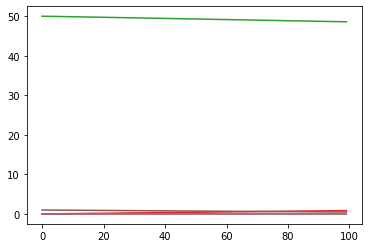

In [113]:
plt.plot(Solution[0])